In [1]:
import os
import sys
from time import time
import numpy as np
import h5py 
import seaborn as sns
import scipy.interpolate as interpolate

import jax
from jax.config import config
config.update("jax_enable_x64", True)
import jax.numpy as np

sys.path.append('/Users/theoares/lqcd_analysis/lqcd_analysis')
# from lqcd_analysis import visualize as plt
import visualize as plt

sys.path.append('/Users/theoares/lqcd/spectral/recon_tools')
# from inverse_problems import jax_spline
import jax_spline

sys.path.append('/Users/theoares/inverse_problems/inverse_problems')
from inverse_problems import nevanlinna as nv

# I/O functions

In [2]:
def phase(z):
    return np.exp(1j*np.arctan2(z.imag, z.real))

In [3]:
def generate():
    #os.system("pushd /Users/theoares/lqcd/spectral/recon_tools; python3 generate.py data.h5; mv data.h5 /Users/theoares/inverse_problems/nevanlinna_cpp/; popd;")
    os.system("pushd /Users/theoares/lqcd/spectral/recon_tools; python3 generate.py data.h5; popd;")

def run(eta="0.0001"):
    os.system(f"/Users/theoares/inverse_problems/nevanlinna_cpp/Nevanlinna data.h5 recon.h5 {eta}")
    
def read_ng(fname):
    with h5py.File(fname, 'r') as ifile:
        freq_re = np.array(ifile['freqs_real'][:], dtype=float)
        freq_im = np.array(ifile['freqs_imag'][:], dtype=float)
        ng_re = np.array(ifile['ng_real'][:], dtype=float)
        ng_im = np.array(ifile['ng_imag'][:], dtype=float)
        freq = freq_re + 1j*freq_im
        ng = ng_re + 1j*ng_im
    return freq, ng

def read_phis(fname):
    with h5py.File(fname, 'r') as ifile:
        phis_re = np.array(ifile['phis_real'][:], dtype=float)
        phis_im = np.array(ifile['phis_imag'][:], dtype=float)
        phis = phis_re + 1j*phis_im
    return phis

def read(fname):
    with h5py.File(fname, 'r') as ifile:
        # Reconstructed frequencies
        start = np.array(ifile['start'][:], dtype=float).item()
        stop = np.array(ifile['stop'][:], dtype=float).item()
        num = np.array(ifile['num'][:], dtype=int).item()
        omega = np.linspace(start, stop, num=num)
        # 
        real = np.array(ifile['recon_real'][:], dtype=float)
        imag = np.array(ifile['recon_imag'][:], dtype=float)
        rho = real + 1j*imag
    return omega, rho

def read_abcd(fname):    
    with h5py.File(fname, 'r') as ifile:
        print(ifile.keys())
        # Reconstructed frequencies
        start = np.array(ifile['start'][:], dtype=float).item()
        stop = np.array(ifile['stop'][:], dtype=float).item()
        num = np.array(ifile['num'][:], dtype=int).item()
        omega = np.linspace(start, stop, num=num)
        tmp = {}
        for key in ['a','b','c','d']:
            tmp[f'{key}_re'] = np.array(ifile[f'{key}_vec_real'][:], dtype=float)
            tmp[f'{key}_im'] = np.array(ifile[f'{key}_vec_imag'][:], dtype=float)
        # Normalize a,b,c,d
        norm = np.max(np.array(list(tmp.values())))
        for key in tmp:
            tmp[key] = tmp[key]/norm
        abcd = {}
        # Rephase a,b,c,d
        for key in ['a','b','c','d']:
            abcd[key] = tmp[f'{key}_re'] + 1j*tmp[f'{key}_im']        
        phi = phase(abcd['a'][0])
        for key in abcd:
            abcd[key] = abcd[key]/phi
    return omega, abcd

def build_bspline(x, y):
    t, c, k = interpolate.splrep(x, y, s=0, k=4)
    bspline = interpolate.BSpline(t, c, k, extrapolate=False)
    return bspline    

def kernel(x, x0, sigma):
    dx = x - x0
    return np.exp(-0.5*dx**2/sigma**2) / (np.sqrt(2*np.pi) * sigma)

In [4]:
def analytic_ft(z, m, beta):
    prefactor = -1*(1 + np.exp(-m*beta))
    pole1 = 1/(z - m)
    pole2 = 1/(z + m)
    return prefactor * (pole1 + pole2)


# Generate data, run reconstruction

In [5]:
# Generate data
generate()

# Compute spectral function
run(eta="0.01")

# Read spectral
omega, rho = read("recon.h5")

~/lqcd/spectral/recon_tools ~/lqcd/spectral/recon_tools
Writing data to: data.h5
Normalization of spectral density 1.0000000000000002
C(t=0) 0.539507026619249 (direct)
C(t=0) 1.0 (spline)
Green's function data written to: data.h5
~/lqcd/spectral/recon_tools

Running Nevanlinna.
Reading input from: data.h5
Writing output to: recon.h5
Running reconstruction with eta = 0.01
Number of measured Matsubara frequencies: 20
Beta is: 100

Matsubara frequencies:
[0 + 0.1256637061435917295385057353312i, 0 + 0.1884955592153875943077586029968i, 0 + 0.2513274122871834590770114706624i, 0 + 0.314159265358979323846264338328i, 0 + 0.3769911184307751886155172059935i, 0 + 0.4398229715025710533847700736591i, 0 + 0.5026548245743669181540229413247i, 0 + 0.5654866776461627829232758089903i, 0 + 0.6283185307179586476925286766559i, 0 + 0.6911503837897545124617815443215i, 0 + 0.7539822368615503772310344119871i, 0 + 0.8168140899333462420002872796527i, 0 + 0.8796459430051421067695401473183i, 0 + 0.942477796076937971

## Plot results

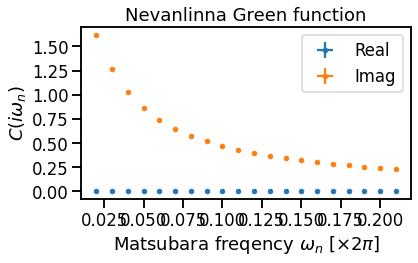

In [6]:
# NG Green function - on imaginary axis
freq, ng = read_ng("recon.h5")
phis = read_phis("recon.h5")

with sns.plotting_context("talk"):
    fig, ax = plt.subplots(1)
    x = freq.imag / (2*np.pi)
    plt.errorbar(ax, x, ng.real, fmt='.', label='Real')
    plt.errorbar(ax, x, ng.imag, fmt='.', label='Imag')

    ax.set_xlabel(r"Matsubara freqency $\omega_n$ [$\times 2\pi$]")
    ax.set_ylabel(r"$C(i\omega_n)$")
    ax.set_title("Nevanlinna Green function")
    ax.legend(loc=0)
    fig.tight_layout()

<KeysViewHDF5 ['a_vec_imag', 'a_vec_real', 'b_vec_imag', 'b_vec_real', 'beta', 'c_vec_imag', 'c_vec_real', 'd_vec_imag', 'd_vec_real', 'eta', 'freqs_imag', 'freqs_real', 'ng_imag', 'ng_real', 'num', 'phis_imag', 'phis_real', 'recon_imag', 'recon_real', 'start', 'stop']>


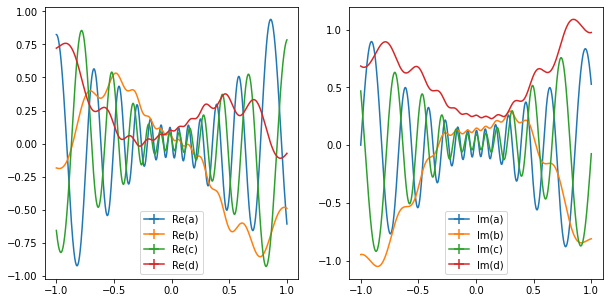

In [7]:
omega, abcd = read_abcd("recon.h5")

fig, axarr = plt.subplots(ncols=2, figsize=(10, 5))
ax1, ax2 = axarr
for key in ['a','b','c','d']:
    y = abcd[f"{key}"].real
    x = omega
    plt.errorbar(ax1, x, y, label=f"Re({key})")

    y = abcd[f"{key}"].imag
    x = omega
    plt.errorbar(ax2, x, y, label=f"Im({key})")

for ax in axarr:
    ax.legend()

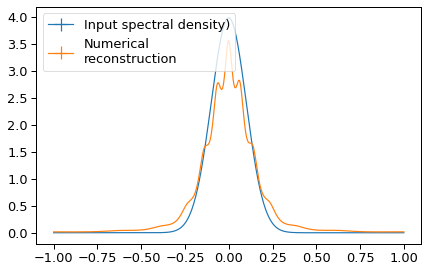

In [8]:
freq, ng = read_ng("recon.h5")
omega, rho = read("recon.h5")

sigma = 0.1

with sns.plotting_context("paper", font_scale=14/9.6):

    fig, ax = plt.subplots(1)
    
    # Expected spectral density
    x = np.linspace(-1, 1, num=1000)
    y = np.exp(-0.5*x**2/sigma**2)/(np.sqrt(2*np.pi)*sigma)
    plt.errorbar(ax, x, y, label="Input spectral density)")
    
    # Reconstructed spectral density
    y = rho.imag
    x = omega
    f = build_bspline(x, y)
    plt.errorbar(ax, x, y, label='Numerical\nreconstruction')

    ax.legend(loc='upper left')
    fig.tight_layout()

# Hardy optimization

## Helper functions

In [9]:
def hardy(k, z):
    return ((z - 1j)/(z + 1j))**k / (np.sqrt(np.pi)*(z + 1j))

def hardy_sum(z, p):
    assert len(p) % 2 == 0
    result = 0*1j
    for k in range(0, len(p), 2):
        ak = p[k]
        bk = p[k+1]
        result += ak*hardy(k, z) + bk*np.conjugate(hardy(k, z))    
    return result

def get_abcd(schur, z):
    arr = np.eye(2, dtype=complex)
    for idx in range(schur.npts):
        arr = arr @ schur.theta_matrix(idx=idx, z=z)
    arr = arr / np.max(arr)  # Normalize entries        
    return arr    

def phase(z):
    return np.exp(1j*np.arctan2(z.imag, z.real))

class ComplexSpline:
    def __init__(self, x, nodes):        
        self.real = jax_spline.InterpolatedUnivariateSpline(x, nodes.real)
        self.imag = jax_spline.InterpolatedUnivariateSpline(x, nodes.imag)

    def __call__(self, x):
        return self.real(x) + 1j*self.imag(x)

class SpectralDensity:
    def __init__(self, abcd, x, eta=1e-4):
        
        self.a = ComplexSpline(x, abcd['a'])
        self.b = ComplexSpline(x, abcd['b'])
        self.c = ComplexSpline(x, abcd['c'])
        self.d = ComplexSpline(x, abcd['d'])
        
    def theta(self, z, p):
        return (self.a(z)*hardy_sum(z, p) + self.b(z)) /\
                (self.c(z)*hardy_sum(z, p) + self.d(z))

    def __call__(self, z, p):
        return nv.inverse_moebius(self.theta(z, p)).imag

class LossFunction:
    def __init__(self, density, xmin=0, xmax=0.2, lam=1e-4):
        self.xmin, self.xmax = xmin, xmax
        self.lam = lam
        self.A = density
        self.dA = jax.jit(jax.grad(density))
        self.d2A = jax.jit(jax.grad(self.dA))        
        
    def __call__(self, p):
        x = np.linspace(self.xmin, self.xmax, num=1000)
        # Normalization term
        A = np.array([self.A(xi, p) for xi in x])
        norm = (1 - np.trapz(x=x, y=A))**2
        # Smoothness term
        d2A = np.array([self.d2A(xi, p) for xi in x])
        smooth = np.trapz(x=x, y=d2A**2)
        return norm + self.lam * smooth
        

## Check density computed using a,b,c,d

<AxesSubplot:>

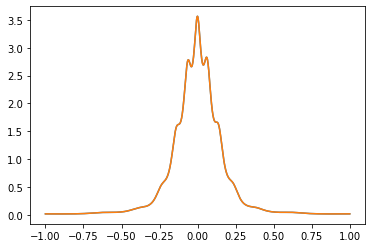

In [10]:
x = np.linspace(-1, 1, num=1000)    
density = SpectralDensity(abcd, x, eta=1e-4)

density = jax.jit(density)

fig, ax = plt.subplots(1)
y = nv.inverse_moebius(density.b(x)/density.d(x)).imag
plt.errorbar(ax, x, y)

y = density(x, p=[])
plt.errorbar(ax, x, y)


## Timing for evaluating loss function

In [11]:
p0 = []
loss = LossFunction(density, xmin=-1.0, xmax=1.0, lam=1e-4)
for _ in range(10):
    ti = time()
    loss(p0)
    tf = time()
    print(tf-ti)




4.114706993103027
0.487548828125
0.48883914947509766
0.5432050228118896
0.661309003829956
0.4349660873413086
0.49692487716674805
0.6173648834228516
0.446382999420166
0.34201598167419434


## Study Nevanlinna coefficients analytically

In [11]:
np.abs(abcd['a'])

Array([0.82498411, 0.82486423, 0.8248626 , 0.82497721, 0.82520594,
       0.82554652, 0.82599661, 0.82655372, 0.82721528, 0.82797861,
       0.82884093, 0.82979936, 0.83085096, 0.83199269, 0.83322143,
       0.83453399, 0.83592713, 0.83739752, 0.83894181, 0.84055656,
       0.84223832, 0.84398357, 0.84578876, 0.84765033, 0.84956467,
       0.85152815, 0.85353713, 0.85558795, 0.85767695, 0.85980044,
       0.86195477, 0.86413624, 0.86634119, 0.86856597, 0.87080692,
       0.87306041, 0.87532283, 0.87759057, 0.87986007, 0.88212777,
       0.88439016, 0.88664375, 0.88888508, 0.89111072, 0.89331728,
       0.89550142, 0.89765982, 0.89978921, 0.90188637, 0.9039481 ,
       0.90597126, 0.90795276, 0.90988955, 0.91177864, 0.91361706,
       0.91540191, 0.91713036, 0.91879959, 0.92040687, 0.92194949,
       0.92342482, 0.92483028, 0.92616334, 0.92742152, 0.92860242,
       0.92970366, 0.93072295, 0.93165805, 0.93250678, 0.93326701,
       0.93393668, 0.93451379, 0.93499639, 0.93538262, 0.93567

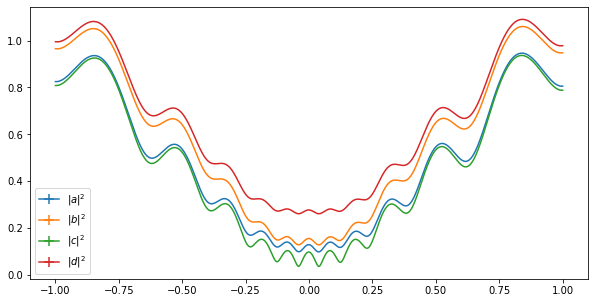

In [12]:
fig, axarr = plt.subplots(ncols=1, figsize=(10, 5))
ax1 = axarr
for key in ['a','b','c','d']:
    y = np.abs(abcd[f"{key}"])
    x = omega
    plt.errorbar(ax1, x, y, label=r'$|' + key + r'|^2$')
ax1.legend()

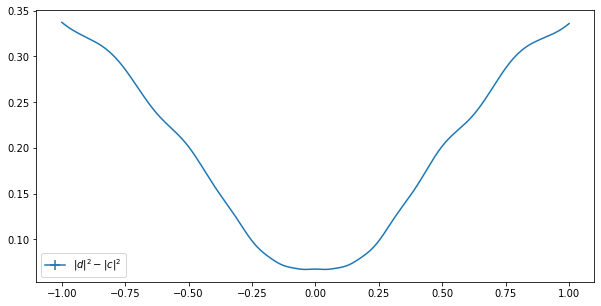

In [13]:
fig, ax1 = plt.subplots(ncols=1, figsize=(10, 5))
y = np.abs(abcd['d'])**2 - np.abs(abcd['c'])**2
x = omega
plt.errorbar(ax1, x, y, label=r'$|d|^2 - |c|^2$')
ax1.legend()

## See possible outcomes of optimization

<AxesSubplot:>

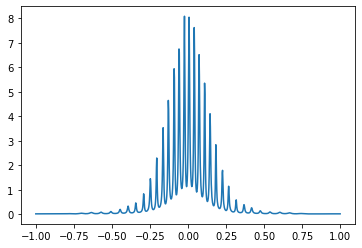

In [15]:
def theta_np1(z, p):
    return hardy_sum(z, p)

p = np.zeros(50)
p = p.at[48].set(1.0)
p = p.at[46].set(1.0)

yp = nv.inverse_moebius((density.a(x)*theta_np1(x, p) + density.b(x))/(density.c(x)*theta_np1(x, p) + density.d(x))).imag
fig, ax = plt.subplots(1)
plt.errorbar(ax, x, yp)

## Run minimization

In [16]:
# import jax.scipy.optimize
# import scipy.optimize
# p0 = np.zeros(10)

# niter = 1

# # for _ in range(niter):
# #     ti = time()
# #     tmp = scipy.optimize.minimize(loss, x0=p0, method='SLSQP', options={'ftol': 1e-9, 'disp': True})
# #     print(tmp.x)

# #     tf = time()
# #     print(f"SLSQP: {tf-ti:0.4f} sec")

# for _ in range(niter):    
#     ti = time()
#     tmp2 = scipy.optimize.minimize(loss, x0=p0, method='BFGS')
#     print(tmp2.x)
#     tf = time()
#     print(f"BFGS: {tf-ti:0.4f} sec")

In [17]:
# fig, ax = plt.subplots(1)

# y = np.array([density(xi, []) for xi in x])
# plt.errorbar(ax, x, y, label='base density')

# # y = np.array([density(xi, tmp.x) for xi in x])
# # plt.errorbar(ax, x+0.001, y, label='SLSQP')

# y = np.array([density(xi, tmp2.x) for xi in x])
# plt.errorbar(ax, x, y, label='BFGS')

# ax.legend()

In [18]:
# import gmpy2 as gmp

In [19]:
# gmp.atan